In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import networkx as nx
import random
from importlib import reload
import warnings
import ot
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap

import surprise as sup

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
# load ann data
resolution = 1000000
population_path = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_anndata.h5ad"

start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()

# sort the object by global bin id
sorted_indices = adata.obs['bin'].argsort()
adata = adata[sorted_indices, :] 

adata

Time taken to read the file: 5.30 seconds
Memory usage: current 1.48 GB, difference +1.48 GB


View of AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'

In [3]:
adata.obs.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ATACSeq_3,CTCF,H3K27ac,H3K27me3,RNA_1,RNA_2,RNA_3,RNA_4,RNA_5,RNA_6
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,0.507852,...,0.375103,0.319337,0.211256,0.577305,0.263153,0.203017,0.128587,0.271721,0.124134,0.093115
chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,0.680719,...,0.586783,0.561063,0.698206,0.735207,0.282745,0.706667,0.265677,0.247106,0.684904,0.225147
chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,0.567134,...,0.467917,0.426098,0.410865,0.458616,0.197587,0.273313,0.233012,0.157297,0.282102,0.108284
chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,0.621495,...,0.493767,0.474813,0.412592,0.640384,0.209920,0.285676,0.147348,0.170128,0.248226,0.116792
chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,0.497991,...,0.427530,0.387846,0.458324,0.391387,0.229293,0.227452,0.157668,0.166332,0.212388,0.116124


In [4]:
def find_outliers(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers(adata.obs['degree'])

print(adata.obs['degree_outlier'].value_counts())

# remove outliers
remove_bins = adata.obs[adata.obs['degree_outlier']].index.to_list()
print(f"Removing top {len(remove_bins)} outlier loci: ")
print(remove_bins)

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()

print('done!')

degree_outlier
False    2431
True      148
Name: count, dtype: int64
Removing top 148 outlier loci: 
['chr1:24', 'chr1:85', 'chr1:195', 'chr2:98', 'chr2:177', 'chr4:112', 'chr4:145', 'chr4:146', 'chr4:147', 'chr5:94', 'chr5:95', 'chr6:103', 'chr7:20', 'chr7:21', 'chr7:22', 'chr7:32', 'chr8:19', 'chr8:20', 'chr8:21', 'chr8:70', 'chr8:130', 'chr9:3', 'chr9:35', 'chr9:124', 'chr10:130', 'chr11:3', 'chr12:3', 'chr13:65', 'chr13:66', 'chr14:3', 'chr14:15', 'chr14:16', 'chr14:17', 'chr14:18', 'chr14:19', 'chr14:125', 'chr16:3', 'chr17:95', 'chr19:61', 'chrX:6', 'chrX:8', 'chrX:9', 'chrX:10', 'chrX:14', 'chrX:15', 'chrX:16', 'chrX:17', 'chrX:18', 'chrX:19', 'chrX:22', 'chrX:23', 'chrX:24', 'chrX:25', 'chrX:26', 'chrX:27', 'chrX:29', 'chrX:34', 'chrX:38', 'chrX:39', 'chrX:40', 'chrX:42', 'chrX:43', 'chrX:44', 'chrX:45', 'chrX:46', 'chrX:48', 'chrX:49', 'chrX:53', 'chrX:54', 'chrX:57', 'chrX:58', 'chrX:60', 'chrX:61', 'chrX:62', 'chrX:63', 'chrX:64', 'chrX:65', 'chrX:66', 'chrX:67', 'chrX:68', 

# Summary plots

In [5]:
adata.var.head()

,read_index,basename,mean_mapq,median_mapq,n_chromosomes,order,n_bins,read_length_bp,genes,n_genes
read_name,,,,,,,,,,
3891ee6d-53d1-4ee0-ba2f-3d22291d4493,0,batch01,50.000000,60.0,2,3,2,5117,Ulk4;Smg7,2
66953ddf-e76d-4cdf-aaf8-be028a2d7b04,1,batch01,50.862069,60.0,8,29,12,10804,Plce1;Slc31a2;Odc1;Gfod2;Lpar1;Rubcn;Zdhhc19;G...,11
ad5b2240-893f-4ed0-a157-c2be66d8d754,2,batch04,50.727273,60.0,5,11,7,4915,Ptprf;Itgb8;Myh9;Nrp1;Dlgap3,5
1cbc7b8c-2ad8-4365-a57c-037fc41af923,3,batch04,15.500000,1.0,2,4,3,6701,Ldlrad4;2610005L07Rik,2
9af4c1b9-a795-43a1-9669-55aff68e3b9d,4,batch03,36.500000,43.0,1,4,3,6737,Potefam3b,1


In [6]:
adata.var['higher_order'] = adata.var['order'] > 2
adata.var['higher_order'].value_counts(normalize=True)

higher_order
True     0.80905
False    0.19095
Name: proportion, dtype: float64

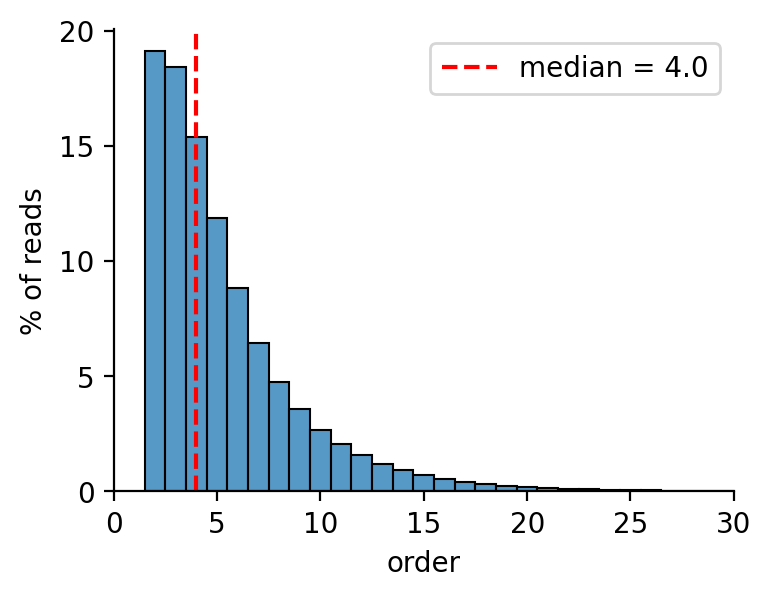

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    data=adata.var,
    x='order',
    discrete=True,
    linewidth=0.75,
    stat='percent',
)

plt.ylabel('% of reads')
plt.xlabel('order')
plt.xlim([0, 30])

# Calculate the median of the 'order' column
median_order = np.median(adata.var['order'])

# Add a vertical line at the median
plt.axvline(
    x=median_order, 
    color='red', 
    linestyle='--',
    label=f'median = {median_order:.1f}'
)

# Add a legend
plt.legend()

sns.despine()

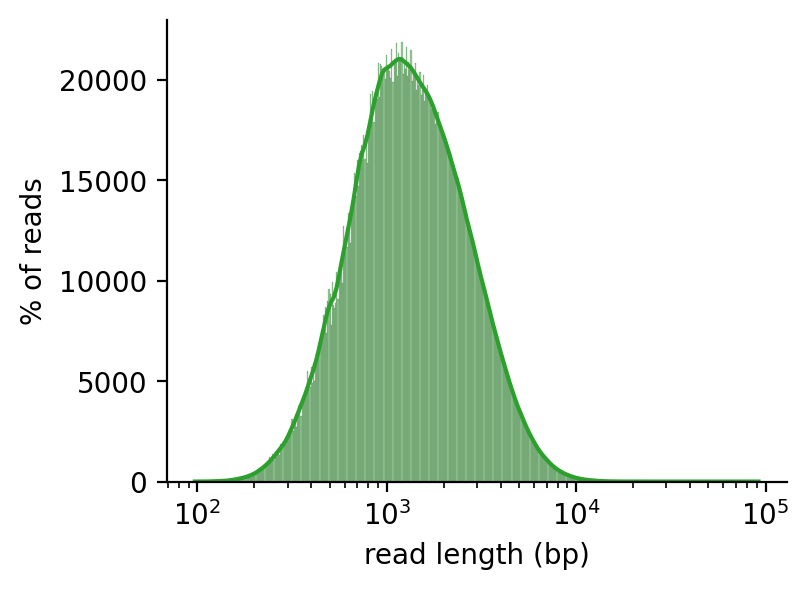

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    data=adata.var,
    x='read_length_bp',
    color='C2',
    kde=True,
    log_scale=True,
)

plt.ylabel('% of reads')
plt.xlabel('read length (bp)')

sns.despine()

# Genome-wide Plot

In [82]:
# n_reads = 500000
# order_threshold = 1

# H = adata.to_df()

# chroms = H.index.to_frame()
# chroms['chrom'] = chroms['bin_name'].str.split(":").str[0]
# chroms['chrom_bin'] = chroms['bin_name'].str.split(":").str[1]

# H.index = adata.obs['bin'].values

# print(f"(raw) {H.shape=}")
# H = H.loc[:, (H.sum() >= order_threshold)]
# print(f"(filtered) {H.shape=}")
# H = H.sample(n_reads, axis=1)
# H = ut.sort_by_lowest_index(H)
# print(f"(sampled) {H.shape=}")

# rows, cols = np.nonzero(H)

# # Create a DataFrame with columns and rows
# df_points = pd.DataFrame({
#     'col': cols, 
#     'row': rows,
#     'chrom': chroms.iloc[rows]['chrom'].values,
# })

# print(f"{df_points.shape=}")

# df_points.head()

(raw) H.shape=(2431, 2756467)
(filtered) H.shape=(2431, 2634312)
(sampled) H.shape=(2431, 500000)
df_points.shape=(1585438, 3)


,col,row,chrom
0,0,0,chr1
1,1,0,chr1
2,2,0,chr1
3,3,0,chr1
4,4,0,chr1


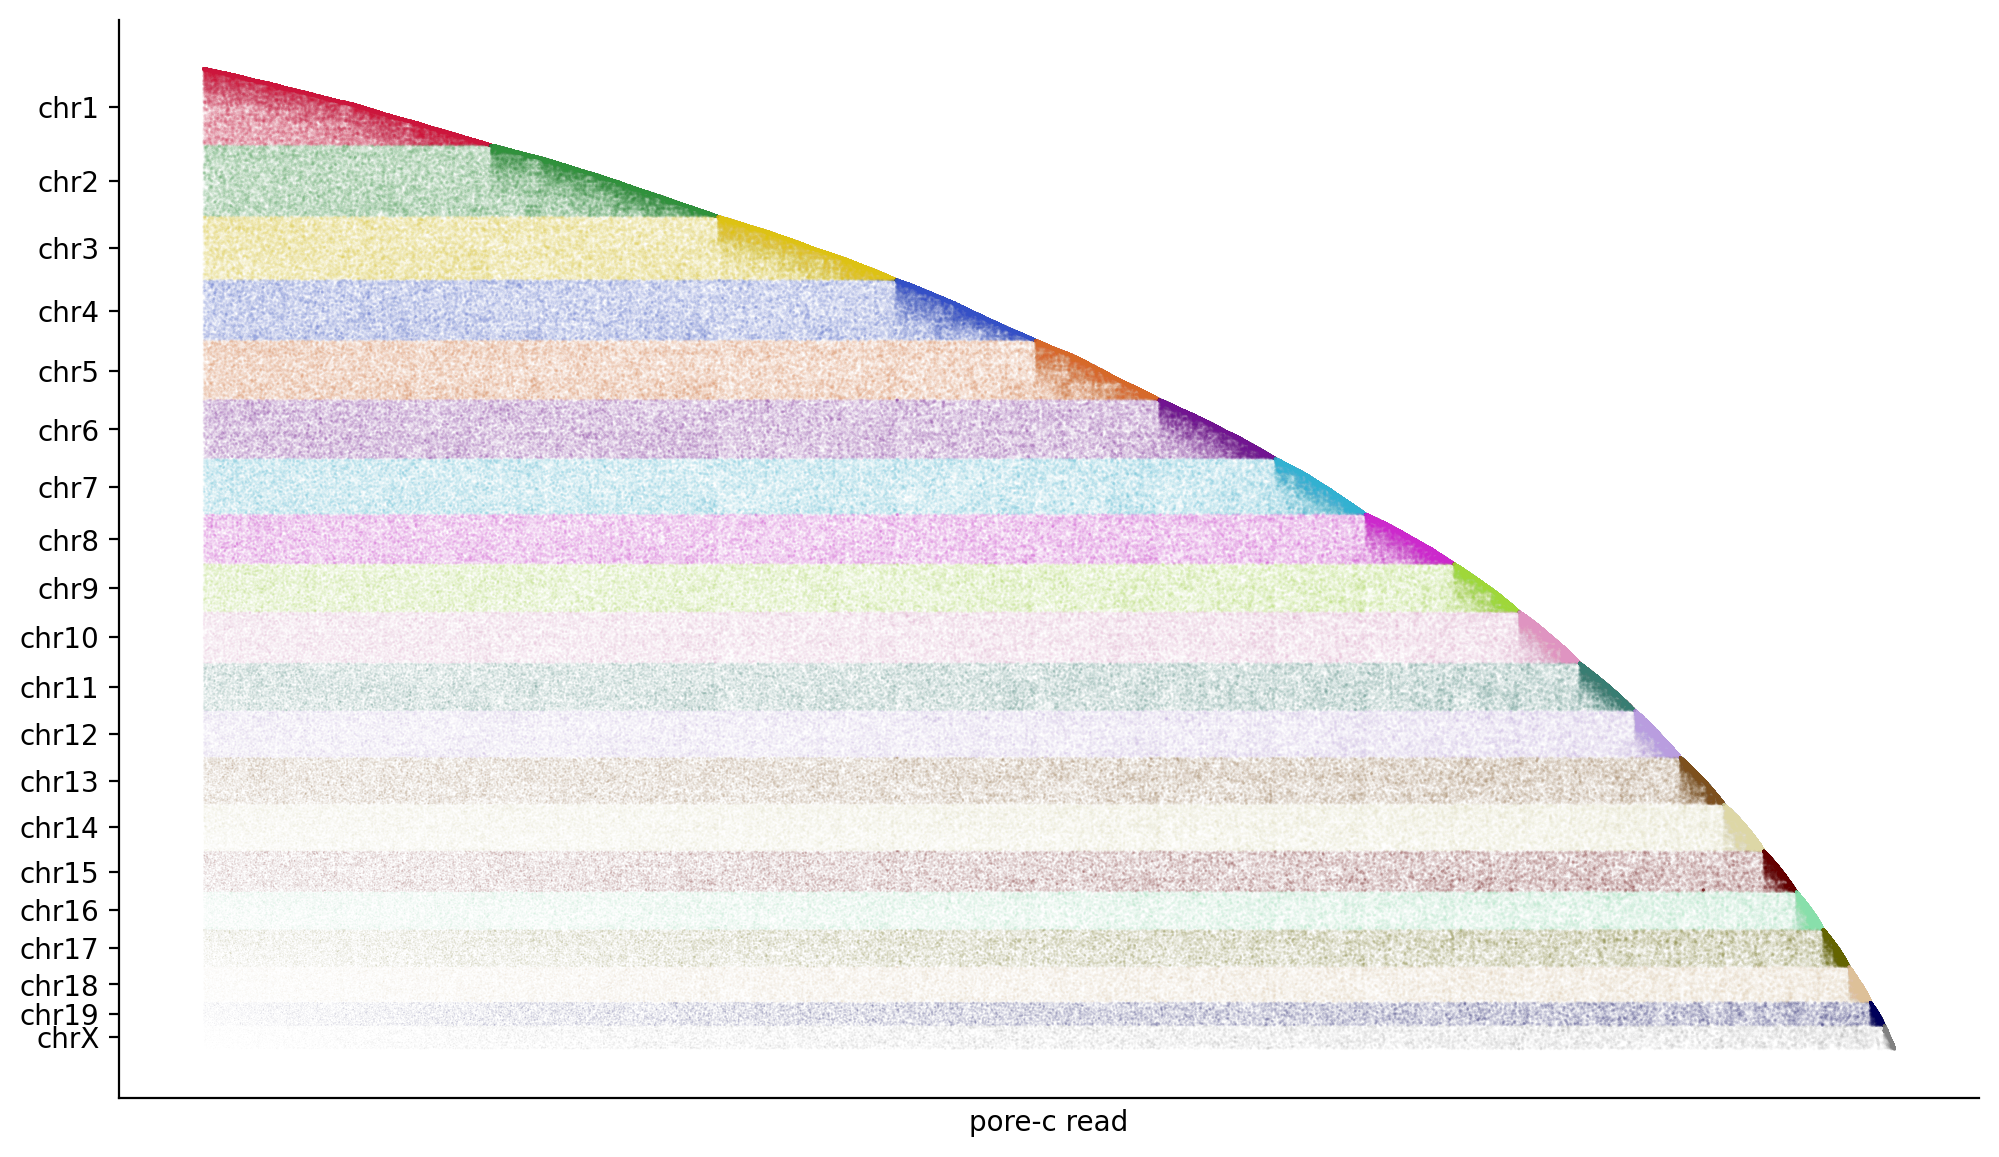

In [85]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 12, 7


# pdf = df_points.copy()
# # Find the coordinates of the reference point
# min_col = 0
# max_row = 1

# # Calculate the squared distances from (min_col, max_row)
# pdf['distance'] = (ut.min_max(pdf['row']) - max_row)**2 + (ut.min_max(pdf['col']) - min_col)**2 

# # Calculate the Euclidean distance
# pdf['distance'] = np.sqrt(pdf['distance'])

# hex_codes = [
#     '#CC153C', '#30913C', '#DDC213', '#3450C6', '#D66929', '#721491',
#     '#33B1D1', '#CC29CC', '#9FD739', '#DF94C1', '#387D72', '#B99DDF', 
#     '#7D501D', '#DDD7A6', '#640000', '#88DFAB', '#646400', '#DDC098', 
#     '#00005A', '#818181',
# ]

# sns.scatterplot(
#     data=pdf,
#     x='col',
#     y='row',
#     marker=".",
#     hue='chrom',
#     ec='none',
#     size='distance',
#     sizes=(0.1, 5),
#     alpha=0.05,
#     palette=hex_codes,
#     legend=False,
# )

# plt.gca().invert_yaxis()
# plt.ylabel('')
# plt.xlabel('pore-c read')

# labels = df_points.groupby('chrom')['row'].mean()
# plt.yticks(labels.values, labels.index)
# plt.xticks([])
# sns.despine()

# Single-chromosome

In [ ]:
chrom_filter = ["chr2"]
order_threshold = 2
cmap = 'inferno'
n_reads = 112979

H = adata.to_df()
print(f"(raw) {H.shape=}")
chroms = H.index.map(lambda x: x.split(":")[0])
H.index = H.index.map(lambda x: int(x.split(":")[1]))
mask = chroms.isin(chrom_filter)
H = H[mask]
H = H.loc[:, (H.sum() >= order_threshold)]

print(f"(filtered) {H.shape=}")
H = H.sample(n_reads, axis=1)
H = H.sort_index()
H = ut.sort_by_lowest_index(H)
print(f"(sampled) {H.shape=}")

rows, cols = np.nonzero(H)

# Calculate column sums
col_sums = H.sum()

# Create a DataFrame with columns and rows
df_points = pd.DataFrame(
    {'col': cols, 
     'row': rows,
     'sum': [col_sums[col] for col in cols]})

# Sort the DataFrame by the 'sum' column
df_points = df_points.sort_values('sum')

# Extract sorted rows and cols
cols = df_points['col'].values
rows = df_points['row'].values
colors = df_points['sum'].values

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 7.5

plt.scatter(
    cols, rows,
    marker=".",
    s=20,
    c=colors,  # Use calculated colors
    cmap=cmap,  # Choose a colormap
    alpha=0.75,
)

plt.gca().invert_yaxis()
plt.xticks([])

sns.despine()
plt.show()

reload(plt2)
plt2.make_colorbar(
    cmap=cmap, 
    title='order',
    tick_labels=[f"{col_sums.min()}", 
                 f"{col_sums.max()}"])
plt.show()

# Merge in the core scores

In [ ]:
chrom_filter = "chr2"
order_threshold = 2
cmap = 'inferno'
n_reads = 112979
score_column = 'hge_logexp_RNA_weighted'
score_quantile = 0.75
include_all = True # if true, include all reads with any core nodes


# read the core scores and define the core
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/core_scores/population_mESC_{resolution}_{chrom_filter}.csv"
scores = pd.read_csv(fpath)
scores['is_core'] = scores[score_column] > np.quantile(scores[score_column], score_quantile)
scores['core_labels'] = np.where(scores['is_core'], "core", 'non-core')
print(scores['core_labels'].value_counts())

core_nodes = scores[scores['is_core']]['bin_name'].values

# load the incidence matrix
H = adata.to_df()
print(f"(raw) {H.shape=}")
chroms = H.index.map(lambda x: x.split(":")[0])
mask = chroms.isin([chrom_filter])
H = H[mask]
H = H.loc[:, (H.sum() >= order_threshold)]

# define the core reads 
core_reads = H.columns[H.loc[core_nodes, ].sum(axis=0) > 2]

print(f"(filtered) {H.shape=}")
H = H.sample(n_reads, axis=1)
H.index = H.index.map(lambda x: int(x.split(":")[1]))
H = H.sort_index()
H = ut.sort_by_lowest_index(H)
print(f"(sampled) {H.shape=}")

# Create a mapping from column index to color
color_map = {i: 'r' if x in core_reads else 'lightgrey' for i, x in enumerate(H.columns)}

# Assign colors based on the column index of each point
colors = [color_map[col] for col in cols]

# Separate core and non-core points
core_rows = [row for row, col in zip(rows, cols) if color_map[col] == 'r']
core_cols = [col for row, col in zip(rows, cols) if color_map[col] == 'r']
non_core_rows = [row for row, col in zip(rows, cols) if color_map[col] == 'lightgrey']
non_core_cols = [col for row, col in zip(rows, cols) if color_map[col] == 'lightgrey']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 6

# Plot non-core points first
plt.scatter(
    non_core_cols,
    non_core_rows, 
    marker="s", 
    s=3,
    c='lightgrey',
)

# Plot core points on top
plt.scatter(
    core_cols,
    core_rows, 
    marker="s",
    s=3,
    c='r',
) 

plt.gca().invert_yaxis()
plt.xticks([])

sns.despine()
plt.show()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2

fig, axs = plt.subplots()

# Create legend handles
legend_handles = [
    mpatches.Patch(color='r', label='core'),
    mpatches.Patch(color='lightgrey', label='non-core'),
]

plt.legend(handles=legend_handles, loc='center')  # Ad2ust location as needed
plt.axis(False)
plt.show()

In [ ]:
plt2.make_colorbar(
    cmap=cmap,
    width=1.25,
    height=0.1,
    orientation='horizontal',
    tick_labels=['low', 'high'],
)
plt.show()

# plot some stuff

In [ ]:
scores.columns

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.25, 2.5


sns.boxplot(
    data=scores,
    x='core_labels',
    y='n_genes',
    showfliers=False,
    palette=['lightgrey', 'r'],
    linecolor='k',
    width=0.65,
)

plt.xlabel("")
plt.ylabel("value")
# plt.title("ATAC-seq")
# plt.title("H3K27me3")
plt.title("n genes")
plt.gca().tick_params(axis='x', rotation=90)

sns.despine()

In [ ]:
scores.head()

In [ ]:
break

In [ ]:
break

In [ ]:
n_reads = 10000

H = adata.to_df().sample(n_reads, axis=1)
print(f"{H.shape=}")
H = ut.sort_by_lowest_index(H)

rows, cols = np.nonzero(H)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

plt.scatter(
    cols, rows, 
    marker="s",
    s=1,
    c='lightgrey',
    alpha=0.75,
)

plt.gca().invert_yaxis()
plt.xticks([])

sns.despine()

plt.show()

In [ ]:
break

In [ ]:
dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_scores/"

file_list = sorted(glob.glob(f"{dpath}*_{resolution}_*"))
print(f"{len(file_list)} files")

read_columns = [
    'bin_name',
    'ce_singular_vector_1', 
    'ce_eigenvector_centrality',
    'ce_betweenness_centrality',
    'ce_pagerank',
    'hge_singular_vector_1',
    'hge_logexp_unweighted',
    'hge_logexp_degree_weighted',
    'hge_logexp_RNA_weighted',
    'hge_logexp_ATAC_weighted',
]

df = []

for fpath in file_list:
    tmp = pd.read_csv(fpath, usecols=read_columns)
    df.append(tmp)

df = pd.concat(df, ignore_index=True)
df = df.set_index('bin_name')
print(f"{df.shape=}")
df.head()

In [ ]:
adata.obs = pd.merge(
    adata.obs, 
    df, 
    how='left',
    left_index=True,
    right_index=True,
    
)
adata.obs.head()